## MLSP Homework 3

### Vijaya Krishna Gopalakrishnan Partha
### vgopala@iu.edu

#### Importing all required libraries

In [286]:
import os
import scipy
import numpy as np
import pandas as pd
import librosa as lb
import matplotlib.pyplot as plt
from IPython.display import Audio

In [60]:
src_dir = 'M:/Spring 2020/MLSP/HW3/data'

### P1: Instantaneous source seperation

#### Loading all the 20 recordings 

In [61]:
ica_data = []
num_recordings = 20

for i in range(num_recordings):
    fs, sr = lb.load(os.path.join(src_dir, 'x_ica_' + str(i+1) + '.wav'), sr = None)
    ica_data.append(np.array(fs))
    
ica_data = np.array(ica_data)
print(ica_data.shape)

(20, 76800)


#### Building covariance matrix

In [62]:
ica_mean = np.mean(ica_data, axis=1).reshape(-1,1)
ica_centered = np.array(ica_data - ica_mean)
ica_cov = np.dot(ica_centered, ica_centered.T)  * (1/(ica_centered.shape[1] - 1))
print(ica_cov.shape)

(20, 20)


#### Eigen decomposition

In [133]:
def eigen_decomp(X, num_eigenvectors, learning_rate):
    max_epochs = 1000
    epoch = 0
    alpha = learning_rate
    eigen_val = []
    eigen_vec = []
    
    for i in range(num_eigenvectors):
        w = np.random.rand(X.shape[0], 1)
        
        for epoch in range(max_epochs):
            w = np.dot(X, w)
            w = w * (1/np.power(np.sum(np.power(w,2)),0.5))
            
        s1 = np.power(np.sum(np.power(np.dot(w.T, X), 2)), 0.5)
        u1 = np.dot(X.T, w) * (1/s1)
        contrib = s1 * np.dot(w, u1.T)
        
        X = X - contrib
        
        eigen_val.append(s1)
        eigen_vec.append(w.reshape(-1,))

    eigen_vec = np.array(eigen_vec)

    return eigen_vec.T, eigen_val

In [134]:
eigen_vec, eigen_val = eigen_decomp(ica_cov, 20, 0.0001) 

In [135]:
print(eigen_val)

[0.19044336343571575, 0.030136737639902423, 0.013155420263504641, 0.005701604194118561, 1.4078860845608916e-08, 1.2759510620161948e-08, 9.547157060446843e-09, 9.192025123385113e-09, 7.517417317931503e-09, 6.52184064760056e-09, 4.96991916440858e-09, 4.6269374748070355e-09, 4.203847070371338e-09, 3.239372294439696e-09, 2.605047863053116e-09, 1.8309503943929108e-09, 1.7127346878178158e-09, 6.918573556828344e-10, 6.468532682049398e-10, 3.663961326388614e-10]


First four eigen values are larger than the other values, so we will take just the first four values in each eigen vector.

In [136]:
eigen_vec = eigen_vec[:,0:4]
eigen_vec = np.multiply(eigen_vec, (1/np.sqrt(eigen_val[0:4])))
Z = np.dot(eigen_vec.T, ica_data)

#### Independent Component Analysis

In [209]:
def ICA(Z, rho, N):
    convergence = []
    delta_W= np.identity(4)
    W = np.identity(4)
    Y = np.dot(W,Z)

    for i in range(0, 2000):
        delta_W = np.dot((N*np.identity(4) - np.dot(np.tanh(Y), np.power(Y, 3).T)), W)
        W = W + rho*delta_W
        Y = np.dot(W,Z)
        convergence.append(np.sum(np.abs(delta_W)))

    return W, convergence

In [210]:
W, convergence = ICA(Z, 0.0000001, Z.shape[1])
pc = np.dot(W, Z)

In [211]:
print(pc.shape)

(4, 76800)


#### Seperated sources

In [212]:
Audio(pc[0,:], rate = sr)

In [213]:
Audio(pc[1,:], rate = sr)

In [214]:
Audio(pc[2,:], rate = sr)

In [215]:
Audio(pc[3,:], rate = sr)

#### Convergence plot

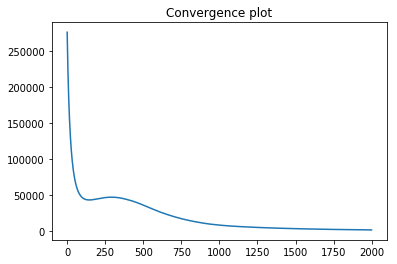

In [216]:
plt.title('Convergence plot')
plt.plot(convergence)
plt.show()

## P2: Ideal Masks

#### Loading data

In [366]:
piano, sr = np.array(lb.load(os.path.join(src_dir, 'piano.wav'), sr = sr))
ocean, sr = np.array(lb.load(os.path.join(src_dir, 'ocean.wav'), sr = sr))

piano_stft = lb.core.stft(piano)
ocean_stft = lb.core.stft(ocean)

S = piano_stft[:513,:]
N = ocean_stft[:513,:]

In [370]:
print(S.shape, N.shape)

(513, 157) (513, 157)


#### Mixing both spectrograms

In [371]:
X = S + N
print(X.shape)

(513, 157)


In [374]:
M_hat_piano = (np.abs(S)**2)/((np.abs(S)**2)+(np.abs(N)**2))

In [375]:
S_recover = np.multiply(M_hat_piano, X)

#### Piano audio before recovery

In [635]:
x_istft = lb.core.istft(X)
Audio(x_istft, rate = 8000)

#### Piano after recovery

In [381]:
piano_recovered = lb.core.istft(S_recover)
Audio(piano_recovered, rate = 8000)

In [642]:
snr = 10 * np.log10(np.sum(np.square(piano[:39936]))/np.sum(np.square(piano[:39936] - piano_recovered)))
print('SNR of recovered audio is: ' + str(np.abs(snr)))

SNR of recovered audio is: 5.068256855010986


#### Trying Ideal Binary Mask

In [387]:
condition = S > N
B = condition.astype(int)

#### Audio after recovering with Ideal Binary Masks

In [389]:
S_ibm = np.multiply(B, X)
piano_recovered_ibm = lb.core.istft(S_ibm)
Audio(piano_recovered_ibm, rate = 8000)

In [641]:
snr = 10 * np.log10(np.sum(np.square(piano[:39936]))/np.sum(np.square(piano[:39936] - piano_recovered_ibm)))
print('SNR using Ideal Binary Masks is: ' + str(np.abs(snr)))

SNR using Ideal Binary Masks is: 4.219180643558502


### Ideal masks did a better job in seperating the two sources than Ideal Binary Masks as it's SNR value is higher than that of IBM.

## P3: Single-Channel Source Seperation

#### Loading data

In [248]:
trs, sr = lb.load(os.path.join(src_dir, 'trs.wav'), sr = None)

#### Creating spectrogram of audio

In [260]:
def dft_matrix(m_size):
    dft_matrix = np.array([[np.exp(-1j * (2 * np.pi * f * n / m_size)) for f in range(0, m_size)] for n in range(0, m_size)])
    return dft_matrix

dft_mat = dft_matrix(1024)
print(dft_mat.shape)

(1024, 1024)


In [261]:
def hann_window(raw_data, m_size):
    hann_w = np.hanning(m_size)
    new_data = []
    
    counter = 0
    
    while counter + m_size <= raw_data.shape[0]:
        data_window = np.multiply(raw_data[counter:counter+m_size], hann_w)
        new_data.append(data_window)
        
        counter += int(m_size/2)
        
    new_data_matrix = np.array(new_data).T
    
    return new_data_matrix

In [262]:
trs_hann = hann_window(trs, 1024)

In [263]:
trs_spec = np.abs(np.dot(dft_mat, trs_hann)[:513,:])

In [264]:
print(trs_spec.shape)

(513, 987)


#### NMF model

In [266]:
def NMF(data, k):
    W = np.random.rand(data.shape[0], k)
    H = np.random.rand(k, data.shape[1])
    I_mat = np.ones(data.shape)
    max_iter = 3000
    iter_ = 0
    
    while iter_ <= max_iter:
        W = np.multiply(W, np.multiply(np.dot(data/(np.dot(W,H)), H.T), (1/(np.dot(I_mat, H.T)))))
        H = H * (np.dot(W.T, (data/np.dot(W, H))))/(np.dot(W.T, I_mat))
        iter_ += 1
        
    return W, H

WS, HS = NMF(trs_spec, 30)

In [267]:
trn, sr = lb.load(os.path.join(src_dir, 'trn.wav'), sr = None)
trn_hann = hann_window(trn, 1024)
trn_spec = np.abs(np.dot(dft_mat, trn_hann)[:513,:])
WN, HN = NMF(trn_spec, 30)

In [274]:
x_nmf, sr = lb.load(os.path.join(src_dir, 'x_nmf.wav'), sr = None)
x_nmf_hann = hann_window(x_nmf, 1024)
x_nmf_spec = np.dot(dft_mat, x_nmf_hann)[:513,:]
x_nmf_spec_abs = np.abs(x_nmf_spec)

In [275]:
W = np.concatenate((WS, WN), axis = 1)

In [276]:
def NMF_h_only(data, k, W):
    H = np.random.rand(k, data.shape[1])
    I_mat = np.ones(data.shape)
    max_iter = 3000
    iter_ = 0
    
    while iter_ <= max_iter:
        H = H * (np.dot(W.T, (data/np.dot(W, H))))/(np.dot(W.T, I_mat))
        iter_ += 1
        
    return H

In [278]:
H = NMF_h_only(x_nmf_spec_abs, 60, W)

In [280]:
mag_mask = np.dot(WS, H[0:30, :])/np.dot(W, H)

speech_est = mag_mask * x_nmf_spec
speech_conjugate = np.flip(np.conjugate(speech_est[1:512, :]), axis = 0)

speech = np.concatenate((speech_est, speech_conjugate), axis = 0)

In [281]:
def idft_matrix(m_size):
    
    dft_matrix = np.array([[np.exp(1j * (2 * np.pi * f * n /m_size)) for f in range(0,m_size)] for n in range(0,m_size)])
    idft_matrix = dft_matrix/m_size
    
    return idft_matrix

idft_mat = idft_matrix(1024)

In [282]:
def reversing_overlap(X, m_size):

    X_out = X[:(X.shape[0] - int(m_size/2)),0]
    for col in range(1,X.shape[1]):
        X_col = X[(X.shape[0] - int(m_size/2)):,col-1] + X[0:int(m_size/2),col]
        X_out = np.concatenate((X_out,X_col))

    X_out = X_out.reshape(-1) 

    return X_out

In [283]:
speech_recovered = np.dot(idft_mat, speech)
speech_time_domain = reversing_overlap(speech_recovered.real, 1024)

#### Before source seperation

In [285]:
Audio(x_nmf, rate = sr)

#### After source seperation

In [284]:
Audio(speech_time_domain, rate = sr)

#### I think SNR for IRM recovered audio will have a higher SNR value as the source was more clearer than the above result.

## P4: Motor Imagery

#### Loading data

In [532]:
eeg = scipy.io.loadmat(os.path.join(src_dir, 'eeg.mat'))

In [533]:
print(eeg.keys())

dict_keys(['__header__', '__version__', '__globals__', 'x_te', 'x_train', 'y_te', 'y_train'])


In [534]:
train_x = eeg['x_train']
train_y = eeg['y_train']
test_x = eeg['x_te']
test_y = eeg['y_te']

In [632]:
print(train_x.shape, train_y.shape)

(768, 3, 112) (112, 1)


#### Blackman window

In [430]:
def blackman_window(data, N, hop_length):
    blackman = np.blackman(N)
    new_data = []
    hop_counter = 0
    
    while hop_counter + N <= len(data):
        frame = data[hop_counter: hop_counter+N]
        vector = np.multiply(frame.T, blackman)
        new_data.append(vector)
        hop_counter = hop_counter + hop_length
        
    return np.array(new_data).T

In [ ]:
dft_bci = create_DFT_Matrix(64)

#### STFT on Mu wave

In [431]:
def stft_on_mu(data):
    stft_mu_vector = []
    
    for i in range(3):
        channel_window = blackman_window(data[:,i], 64, 48)
        stft_mu = np.abs(np.dot(dft_bci, channel_window))[2:7,:].reshape(-1,1)
        stft_mu_vector.append(stft_mu)
        
    return np.array(stft_mu_vector).reshape(-1,1)

In [444]:
train_x_mu = []
test_x_mu = []

for i in range(train_x.shape[2]):
    train_x_mu.append(stft_on_mu(train_x[:,:,i]))

for i in range(test_x.shape[2]):
    test_x_mu.append(stft_on_mu(test_x[:,:,i]))
    
train_x_mu = np.array(train_x_mu).T.reshape(225,112)
test_x_mu = np.array(test_x_mu).T.reshape(225,28)

In [447]:
train_x_mu, test_x_mu =  train_x_mu.T, test_x_mu.T

In [541]:
print(train_x_mu.shape, test_x_mu.shape)

(112, 225) (28, 225)


#### Using NMF for dimension reduction
#### Using NMF function written for previous problem 

In [549]:
ranks = [2, 4, 6, 8, 10, 15, 20]
rank_dict_train = {}
rank_dict_test = {}

for rank in ranks:
    rank_dict_train[rank] = NMF(train_x_mu, rank)
    
for rank in ranks:
    rank_dict_test[rank] = NMF(test_x_mu, rank)

In [551]:
rank_dictH_train = {}
rank_dictH_test = {}

for rank in ranks:
    rank_dictH_train[rank] = NMF(rank_dict_train[rank][0], rank)
    
for rank in ranks:
    rank_dictH_test[rank] = NMF(rank_dict_test[rank][0], rank)

#### kNN classifier

In [640]:
def euclidean_distance(x1,x2):
      return np.sqrt(np.sum(np.square(x1 - x2)))
    
def neighbors(train_x, train_y, test_x, test_y, k):
    distances = []
    
    for i in range(len(train_x)):
        dist = euclidean_distance(test_x, train_x[i])
        distances.append((dist, train_y[i]))
        
    distances.sort(key=lambda x: x[0])
    neighbors = distances[:k]
    neighbors = [n[1][0] for n in neighbors]
    
    return(max(neighbors, key = neighbors.count))

accuracy_df = pd.DataFrame(columns = num_neighbours, index = ranks)

for rank in ranks:
    for k in num_neighbours:
        predictions = list()

        for i in range(rank_dict_test[rank][0].shape[0]):
            pred = neighbors(rank_dict_train[rank][0], train_y, rank_dict_test[rank][0][i], test_y, k)
            predictions.append(pred)
            
        correct_pred_count = 0
        for i in range(len(predictions)):
            if predictions[i] == test_y[i]:
                correct_pred_count += 1

        accuracy_df[k][rank] = correct_pred_count/28

print('Rows in the dataframe are k values and columns have the ranks.')
print(accuracy_df)

Rows in the dataframe are k values and columns have the ranks.
          3         5         7         9         11        13
2   0.428571  0.357143  0.392857  0.357143  0.428571  0.357143
4   0.428571  0.464286  0.464286  0.464286  0.428571  0.428571
6   0.392857  0.321429  0.321429  0.357143  0.392857  0.392857
8   0.464286       0.5  0.535714  0.535714  0.535714       0.5
10  0.535714  0.464286  0.392857  0.464286  0.357143  0.392857
15  0.392857  0.357143  0.357143  0.428571  0.392857  0.285714
20  0.535714       0.5  0.464286  0.428571  0.571429  0.535714
